Seq2Seq: 是一个encoder & decoder的架构，使用RNN处理一个任意长度的原句子 到另外一个任意长度的句子。
编码器/ 解码器都使用RNN，encoder是编码器 是可以是双向的，decoder是解码器不可以，
解码器使用另一个RNN来输出/ 预测。
编码器：Encoder的最后状态，作为解码器：Decoder的初始状态跟输入合并在一起。

训练时：
Decoder使用目标句子作为输入。

BLEU：处理两个句子的长度，衡量生成序列的好坏

In [67]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

In [68]:
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器。"""
    # RNN
    def __init__(self, vocab_size, embed_size, num_hiddens, 
                 num_layer, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layer, 
                          dropout=dropout)
        
   
    def forward(self, X, *args):
        X = self.embedding(X)
        # permute(1, 0, 2)：改变位置，
        X = X.permute(1, 0, 2)
        output, state = self.rnn(X)
        # output：每一个时刻最后的输出，state：最后一个时刻所有层的输出
        return output, state

In [69]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, 
                         num_layer=2)
encoder.eval()
# 4: batch size, 7: size of the sentense
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)

In [70]:
output.shape

torch.Size([7, 4, 16])

In [71]:
# 2: num of layers
state.shape

torch.Size([2, 4, 16])

In [72]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器。"""
    def __init__(self, vocab_size, embed_size, num_hiddens, 
                 num_layer, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size+num_hiddens, num_hiddens, num_layer, 
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    # init_state(): 输入是encoder的outputs -> outputs = output+state
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]
     
    # 与解码器并在一起输出
    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)
        # state[-1]：最后的时刻最后一层的输出状态
        # repeat(X.shape[0], 1, 1)：重复encoder的输出，让它符合decoder的输入状态
        # context：上下文
        context = state[-1].repeat(X.shape[0], 1, 1)
        # cat()：decode的RNN的输入 -> 当前embedding的输出 +编码最后时刻的context
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        return output, state

In [73]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, 
                         num_layer=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)

In [74]:
output.shape

torch.Size([4, 7, 10])

In [75]:
state.shape

torch.Size([2, 4, 16])

In [76]:
def sequece_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32, 
                        device=X.device)[None, :] < valid_len[:, None]
    
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
# 屏蔽不相关的项: [1, 2] -> 保留第一个句子的第一个，第二个句子的第二个
sequece_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [77]:
# # @save
# class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
#     """带遮蔽的softmax交叉熵损失函数"""
#     # pred的形状：(batch_size,num_steps,vocab_size)
#     # label的形状：(batch_size,num_steps)
#     # valid_len的形状：(batch_size,)
#     def forward(self, pred, label, valid_len):
#         weights = torch.ones_like(label)
#         weights = sequence_mask(weights, valid_len)
#         self.reduction='none'
#         unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
#             pred.permute(0, 2, 1), label)
#         weighted_loss = (unweighted_loss * weights).mean(dim=1)
#         return weighted_loss

class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # 解码器的输出预测有很多是填充的vocab_size
    # 不计算填充的值的softmax，每个句子填充的weight=0 有效的weight=1
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequece_mask(weights, valid_len)
        self.reduction = 'none'
        # unweighted_loss = super(MaskedSoftmaxCELoss, 
        #                         self).forward(pred.permute(0, 2, 1), label)
        unweighted_loss = super().forward(pred.permute(0, 2, 1), label)
        
        # dim=1：每个句子取平均，每个样本 返回一个loss
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [78]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long), 
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In [79]:

def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            # 梯度清零
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            # bos: begain of sentence
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()      # 损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

loss 0.020, 11826.9 tokens/sec on cpu


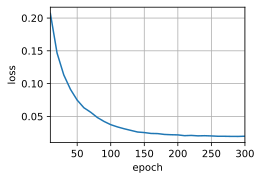

In [80]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)

# 使用encoder和decoder创建网络，然后训练
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [81]:
# 预测
# @save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # Encoding
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    # decode
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    
    # 添加批量轴
    # 第一步：加上bos，包成一个tensor
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        # 去掉维度，变成integer
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
        
    # 输出预测
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [82]:
# # @save
# def bleu(pred_seq, label_seq, k): 
#     """计算BLEU"""
#     pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
#     len_pred, len_label = len(pred_tokens), len(label_tokens)
#     # 公式
#     score = math.exp(min(0, 1 - len_label/ len_pred))
    
#     for n in range(1, k+1):
#         num_matches, label_subs = 0, collections.defaultdict(int)
#         for i in range(len_label - n + 1):
#             label_subs[' '.join(label_tokens[i: i+n])] += 1
#         for i in range(len_pred - n + 1):
#             if label_subs[' '.join(pred_tokens[i: i+n])] > 0:
#                 # 查看预测值是否在label中
#                 num_matches += 1
#                 # 在label中减去已经查询到的
#                 label_subs[' '.join(pred_tokens[i: i+n])] -= 1
#         score *= math.pow(num_matches / (len_pred-n+1), math.pow(0.5, n))
        
#     return score

# No space
def bleu(pred_seq, label_seq, k):  
    """计算 BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [83]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va le chercher !, bleu 0.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est <unk> gros ., bleu 0.548
i'm home . => je suis parti ., bleu 0.512
